In [1]:
from yamlscript_histdata import histdata_parser
from plot_classes import *
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

In [2]:
df1, df2 = histdata_parser("CR_ttc_prefit.yaml")

histdata_parser ran in 34 ms.


In [3]:
dflist          = df1.loc[['Samples']]
hist_list       = list(reversed(df1.loc[['Samples'], 'Yield'].tolist()))
histlist_edges  = df2.loc[['BinEdges'],0][0]
histlist_labels = ['$' + x.replace('#', '\\') + '$' for x in reversed(dflist.index.get_level_values(1).tolist())]
total_yield     = df1.loc[['Total'],'Yield'][0]
data_yield      = df1.loc[['Data'],'Yield'][0]
total_errup     = df1.loc[['Total'],'Yield'][1]
total_errdown   = df1.loc[['Total'],'Yield'][2]
xaxis_label     = '$' + df2.loc[['XaxisLabel'], 0][0].replace('#', '\\') + '$'

In [4]:
len(hist_list)

19

In [39]:
# class HandlerSquare(HandlerPatch):
#     def create_artists(self, legend, orig_handle,
#                        xdescent, ydescent, width, height, fontsize, trans):
#         center = xdescent + 0.5 * (width - height), ydescent
#         p = mpatches.Rectangle(xy=center, width=height,
#                                height=height, angle=0.0)
#         self.update_prop(p, orig_handle, legend)
#         p.set_transform(trans)
#         return [p]

    
from plot_classes import EmptyPlot


class PythRatio(EmptyPlot):
    
    
    def __init__(self, spacing=0, stretch=4, rcp_kw={}, **kwargs):
        
        super().__init__(layout=(2,1), **kwargs)
        
        self.create_canvas()
        self.make_grid(hspace=spacing, height_ratios=[stretch,1])
        self.mainax = self.make_subplot(0, 1, 0, 1)
        self.botax  = self.make_subplot(1, 2, 0, 1)
        
        ### provisional
        self.store_data()
        ###

        # create list for colors of stack plot
        self.stack_colorlist = []
        self.set_stack_color()
        
        # set default rcParams for the plot
        self.rcp_dict = {"legend.handletextpad": 0.15,
                         "legend.handlelength" : 1.7,
                         "legend.columnspacing": 0.5,
                         "legend.labelspacing" : 0.1,
                         "legend.markerscale"  : 1.2,
                         "legend.handletextpad": 0.15,
                         "xaxis.labellocation" : 'right', # location of x label w.r.t. x axis
                         "yaxis.labellocation" : 'center', # location of y label w.r.t. y axis
                         "axes.labelpad"       : 1, # distance of axis label from axis tick labels
                         "font.size"           : 10, # x, y label AND ticks label font size
                         "axes.titlesize"      : 15,
                        }
        
        # update dict if user has passed any rcParam values in the constructor
        self.rcp_dict.update({k: v for k, v in rcp_kw.items() if k in mpl.rcParams})
        
        # set parameters
        self.config_rcParams(self.rcp_dict)
        
        
    def fill(self, obj):
        
        if isinstance(obj, list):
            self.data_container = obj
        else:
            self.data_container.append(obj)
            self.active_data = self.data_container[0]

        self.store_data()
    
    
    def store_data(self):
        
        ### these should be retrived internally from filled object ---------------------
        self.dflist          = dflist
        self.histlistedges   = histlist_edges
        self.histlisttotal   = total_yield
        self.histlistdata    = data_yield
        self.histlistlabels  = histlist_labels
        self.histlisterrup   = total_errup
        self.histlisterrdown = total_errdown
        # the lower part in the ratio plot is the data divided by the total hist cont
        self.ratiovalues = [i/j for i, j in zip(self.histlistdata, self.histlisttotal)]
        ### ----------------------------------------------------------------------------
        
    
    def set_stack_color(self, colormap="viridis", reverse=False):
        # create custom color map for stack histogram
        
        clist = []
        n = len(self.dflist)
        pct_max, pct_min = 99, 1 # max and min percentile of color ramp
        cmap = mpl.cm.get_cmap(colormap)
        
        # list of values between 0.00 and 1.00; length equals length of data source
        sequence = list(i/100 for i in (np.arange(pct_min, pct_max, (pct_max-pct_min)/n)))
        
        # reverse if required
        sequence = sequence if not reverse else reversed(sequence)
        
        # create list of colors
        for i in sequence:
            color = cmap(i) 
            clist.append(color)
        
        self.stack_colorlist = clist

        
    def set_mainax(self):
                
        # stacked histogram
        hep.histplot(self.data_container, ax=self.mainax, bins=self.histlistedges, stack=True, fill=True, 
                     label=self.histlistlabels, color=self.stack_colorlist, edgecolor='k')
        
        # data scatter points
        hep.histplot(self.histlistdata, ax=self.mainax, bins=self.histlistedges, histtype='errorbar', color='k', 
                     label="Data", markersize=self.rcp_dict["font.size"])
        
        # data error histograms
        self.mainax.stairs(self.histlisttotal, edges=self.histlistedges, color='k', alpha=0.3, hatch='///', label="Uncertainty", 
                           baseline=[self.histlisttotal[i] + self.histlisterrup[i] for i in range(len(self.histlisttotal))])
        self.mainax.stairs(self.histlisttotal, edges=self.histlistedges, color='k', alpha=0.3, hatch='///',
                           baseline=[self.histlisttotal[i] + self.histlisterrdown[i] for i in range(len(self.histlisttotal))])
        
        # adjust ticks
        self.mainax.tick_params(direction='in', length=10, bottom=True, top=True, left=True, right=True,
                                labelsize=self.rcp_dict["font.size"])
        self.mainax.tick_params(direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
        
        # show full number without scientific notation
        self.mainax.ticklabel_format(style='plain')
        
        self.mainax.set_xticks(np.linspace(self.histlistedges[0], self.histlistedges[-1], len(self.histlistedges)))
        self.mainax.set_xticklabels([]) # suppress x tick labels for main plot
        
        # add atlas logo and text
        hep.atlas.label(ax=self.mainax, label="Internal", data=True, lumi=139)
        
        self.set_legend()
        
    
    def set_legend(self):
        
        self.mainax.legend(ncol=2, handlelength=self.rcp_dict["legend.handlelength"], fontsize=self.rcp_dict["font.size"])
        # self.mainax.legend([main[0]], ["ciaooo"], handler_map={main[0]: HandlerSquare()}, ncol=2, handlelength=1.7)        
        
        # scale ylim automatically for optimal legend placement
        hep.plot.yscale_legend(ax=self.mainax)
        
        # sort legend entries
        hep.sort_legend(self.mainax)

        
    def set_botax(self):

        # ratio data
        hep.histplot(self.ratiovalues, ax=self.botax, bins=self.histlistedges, histtype='errorbar', color='k', 
                     markersize=self.rcp_dict["font.size"])
        
        # create ratio error values
        self.histlisterrup_ratio = [(self.histlisttotal[i] + self.histlisterrup[i])/self.histlisttotal[i] for i in range(len(self.histlisttotal))]
        self.histlisterrdown_ratio = [(self.histlisttotal[i] + self.histlisterrdown[i])/self.histlisttotal[i] for i in range(len(self.histlisttotal))]
        
        # plot them
        self.botax.stairs(self.histlisterrup_ratio, edges=self.histlistedges, color='k', alpha=0.3, hatch='///', baseline=1)
        self.botax.stairs(self.histlisterrdown_ratio, edges=self.histlistedges, color='k', alpha=0.3, hatch='///', baseline=1)
        
        # adjust ticks
        self.botax.tick_params(direction='in', length=10, bottom=True, top=True, left=True, right=True,
                               labelsize=self.rcp_dict["font.size"])
        self.botax.tick_params(direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
        
        self.botax.set_xticks(np.linspace(self.histlistedges[0], self.histlistedges[-1], len(self.histlistedges)))

        # set y limits
        self.botax.set_ylim(self.ylims)
        
        # draw horizontal line at y=1
        self.botax.axhline(1, color='k', linestyle='--')
        
        self.set_bot_yticks()
        
        
    def set_bot_yticks(self):
                
        self.botax.set_yticks(self.ybotrange)
        self.botax.set_yticklabels(self.ybotlabels, fontsize=self.rcp_dict["font.size"])
        
        
    def set_bot_yaxis(self, ylims, step, edges=True):
        
        self.ylims = ylims
        self.ystep = step
        self.ybotrange = np.arange(ylims[0], ylims[-1]+step, step)
        print(self.ybotrange)
        self.ybotlabels = [f"{x:.2f}" for x in self.ybotrange]
        
        if not edges:
            self.ybotlabels[0] = ""
            self.ybotlabels[0-1] = ""
        
        
    def axes_labels(self, fontsize, labelpad=5, **titles_kw):
        # set axis titles according to user input
        
        self.fill_titlesdict(**titles_kw)
        print(titles_kw)
        self.set_xtitles(self.botax, "xbot", fontsize=fontsize, labelpad=labelpad)
        self.set_ytitles(self.mainax, "ymain", fontsize=fontsize, labelpad=labelpad)
        self.set_ytitles(self.botax, "ybot", fontsize=fontsize, labelpad=labelpad)
        
        
    def ratio_plot(self):
        
        self.set_mainax()
        self.set_botax()
        
        # set master title
        self.mainax.set_title(self.master_title, fontsize=self.rcp_dict["axes.titlesize"])

        
    def display(self, save_name="", dpi=1000):
        
        self.ratio_plot()
        
        if save_name:
            self.saveimage(save_name, dpi)

legend.handletextpad 0.15
legend.handlelength 1.7
legend.columnspacing 0.5
legend.labelspacing 0.1
legend.markerscale 1.2
xaxis.labellocation right
yaxis.labellocation center
axes.labelpad 1
font.size 10
axes.titlesize 20
{'xbot': '$BDT(t\\bar{t} + \\geq1c)$', 'ymain': 'Events', 'ybot': 'Data/Pred'}
okx
oky
oky
[0.5  0.75 1.   1.25 1.5 ]


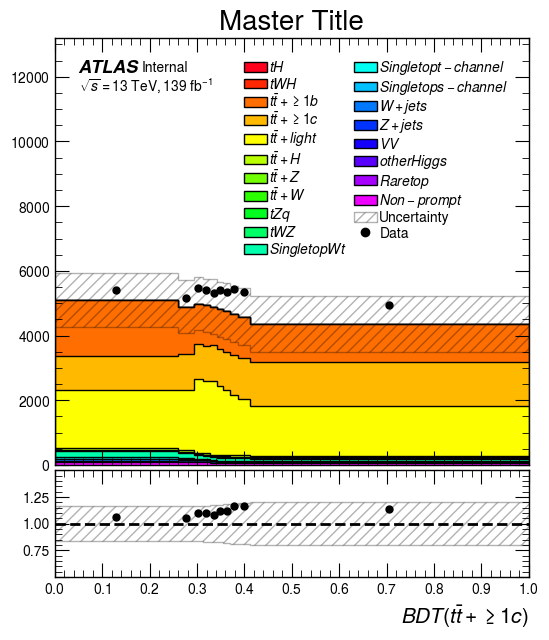

In [41]:
my_dict={"axes.titlesize": 20}

obj1 = PythRatio(size=(6,7), title="Master Title", spacing=0.02, rcp_kw=my_dict)
obj1.fill(hist_list)
obj1.set_stack_color(reverse=True, colormap="gist_rainbow")
obj1.axes_labels(15, xbot=xaxis_label, ymain="Events", ybot="Data/Pred")
obj1.set_bot_yaxis([0.5, 1.5], 0.25, edges=False)
obj1.display()